In [ ]:
!pip install segmentation-models albumentations

In [1]:
%load_ext autoreload
%autoreload 2

# include include folder
import sys
sys.path.append("./miniaturautonomie_lanedetection/include/")
sys.path.append("./include/")

from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import os
import fnmatch
import random
import cv2
import json

import supervisely_parser as svp
import render
import evaluation as evl
import loss
import statistic
from DataGenerator import DataGenerator

import segmentation_models as sm # for simple segmentation architecture

import albumentations as Alb

Segmentation Models: using `keras` framework.


In [7]:
name = 'reference_1' # should be changed for every new test run

annotation_path = './annotation_v3.0/'
image_path = './data/'
packages = ['knuff_main1', 'knuff_main2', 'knuff_main3', 'knuff_hill', 'highway', 'knuff_main5', 'knuff_main6']

output_dir = f"./output/{name}"
model_path = f"{output_dir}/model.h5"

input_img_size = (480, 640)

class_names = np.array(['road_edge', 'middle_curb', 'guide_lane', 'solid_lane', 'hold_line', 'zebra', 'background'])
number_classes = 7 # outer, middle_curb, guide_lane, solid_lane, hold_line, zebra, background
output_width = 640 
output_height = 224 
input_width = 640 
input_height = 224

val_size = 0.2 # percentage
augmentation = False

batch_size = 8
epochs = 90

transform = Alb.Compose([
    Alb.ShiftScaleRotate(p=0.2),
    Alb.RandomContrast(p=0.4),
    Alb.RandomBrightness(limit=[-0.2,0.2], p=0.4)
])

params = {
    'batch_size': batch_size,
    'input_img_size': input_img_size,
    'target_img_size': (output_height, output_width),
    'shuffle': True,
    'n_channels': number_classes,
    'transform': transform,
    'augmentation': augmentation
}

#################################################################
# run only if to rerender all masks or new packages are added
#render.render_packages(packages, annotation_path, input_img_size)
#################################################################

# create output dir for every generated file
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# generate absolute list of all img and masks paths
image_paths = []
mask_paths = []
# for package
for index in range(len(packages)):
    image_base_path = f"{image_path}{packages[index]}/"
    masks_base_path = f"{annotation_path}{packages[index]}/masks/"

    file_list = os.listdir(masks_base_path)
    pattern = '*.png'
    for filename in file_list:
        if fnmatch.fnmatch(filename, pattern):
            mask_paths.append(os.path.join(masks_base_path, filename))
            image_name = filename[:len(filename)-3]+"jpg"
            image_paths.append(os.path.join(image_base_path, image_name))
            
size_all = len(image_paths)
random.Random(size_all).shuffle(image_paths)
random.Random(size_all).shuffle(mask_paths)

random.Random(size_all).shuffle(image_paths)
random.Random(size_all).shuffle(mask_paths)

/home/danielriege/env_train/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1770: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/danielriege/env_train/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1744: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


## Data Info

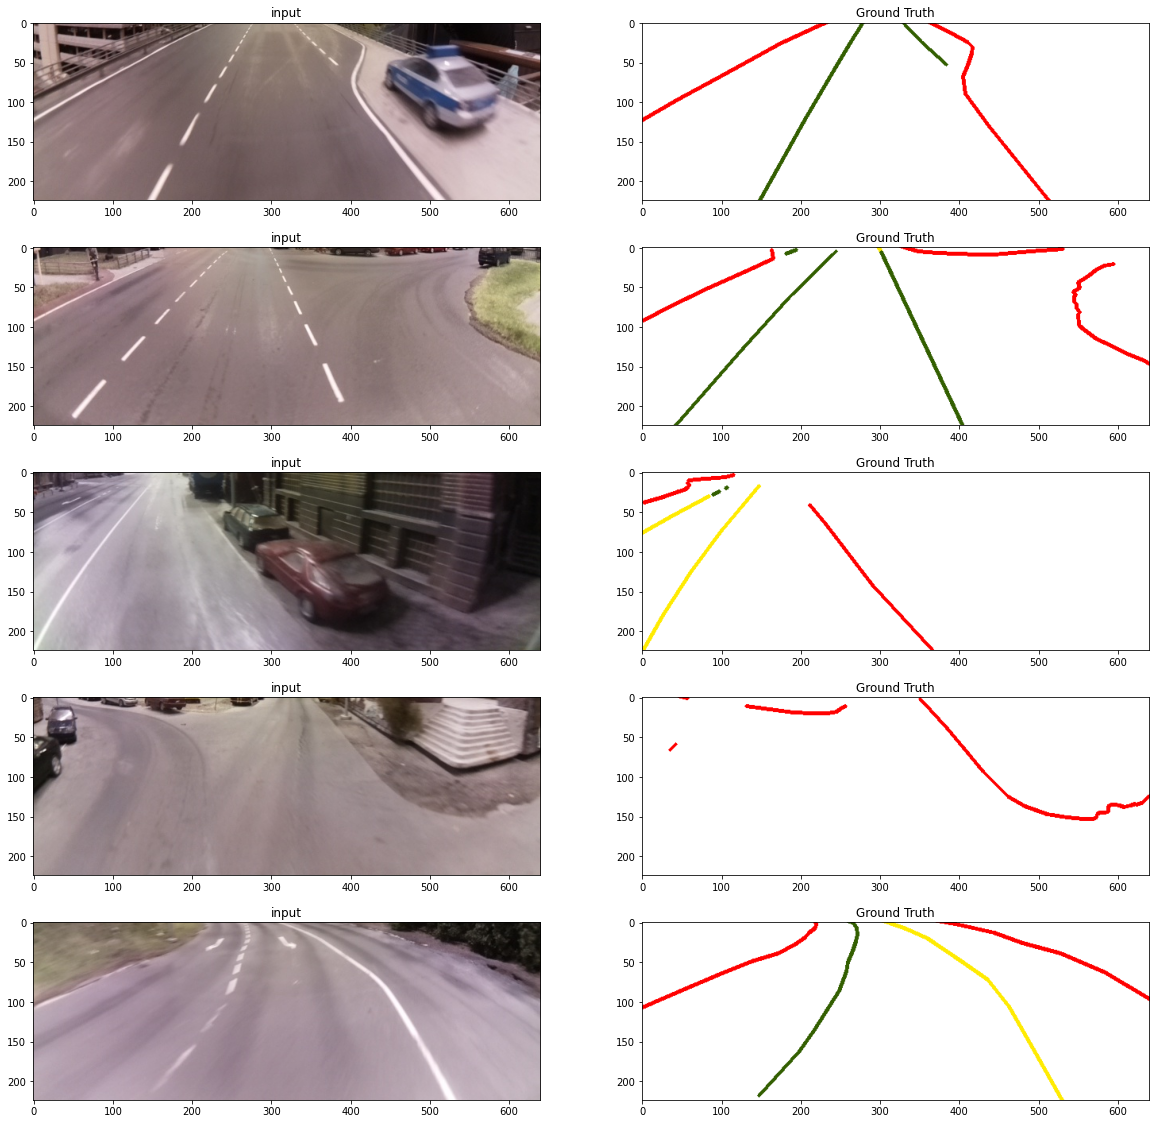

In [7]:
c = 5
f, axs = plt.subplots(c, 2, figsize=(20,c*4))
i = 0

batch_input_test = image_paths#[:c]
batch_target_test = mask_paths#[:c]
info_gen = DataGenerator(batch_input_test, batch_target_test, **params)
images, data = info_gen.data_generation(batch_input_test, batch_target_test)

for y in range(c):
    axs[y,0].imshow(images[i])
    axs[y,0].title.set_text('input')
    rgb_gt = render.render_rgb(data[i].astype(int))
    
    axs[y,1].imshow(rgb_gt)
    axs[y,1].title.set_text('Ground Truth')
    i += 1

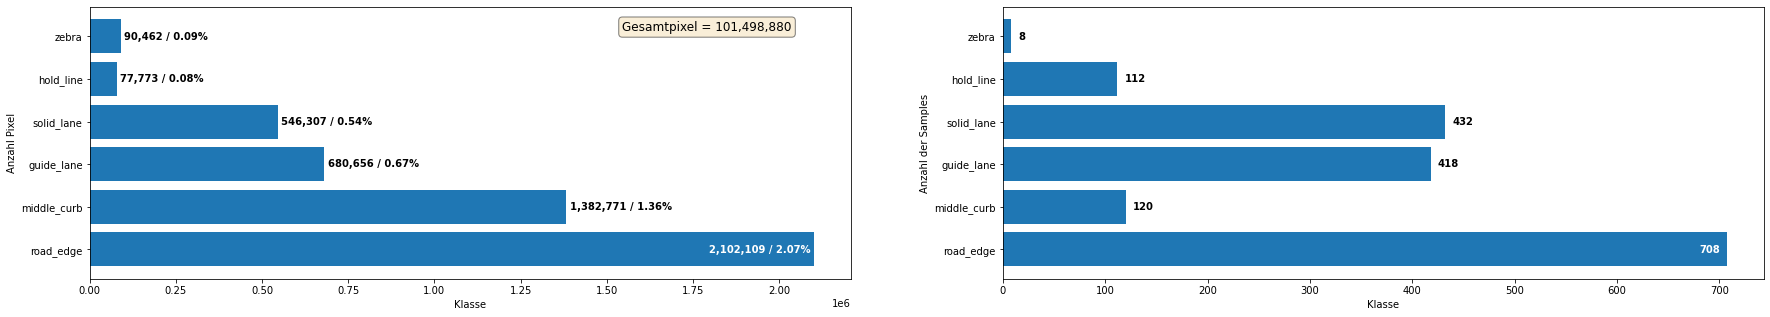

In [8]:
##########################################
# PLOT
#########################################
ratio_data, index_data = statistic.calc_ratio_data(data, number_classes, class_names)
hist_by_pixel, hist_by_images = statistic.calc_chart_data(ratio_data, number_classes)
sum_all_pixels = len(batch_input_test) * input_width * input_height

f, axs = plt.subplots(1,2,figsize=(30,5))
x_pos = [i for i, _ in enumerate(class_names[:-1])]
bar1 = axs[0].barh(x_pos, hist_by_pixel)
axs[0].set_xlabel("Klasse")
axs[0].set_ylabel("Anzahl Pixel")
axs[0].set_yticks(x_pos)
axs[0].set_yticklabels(class_names[:-1])

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
axs[0].text(0.7, 0.95, f'Gesamtpixel = {sum_all_pixels:,.0f}', transform=axs[0].transAxes, fontsize=12, verticalalignment='top', bbox=props)
for rect in bar1:
    width = rect.get_width()
    if width < 1_500_000:
        ha = 'left'
        pos = width + 10000
        color = 'black'
    else:
        ha = 'right'
        pos = width - 10000
        color = 'white'
    ratio = width / sum_all_pixels
    axs[0].text(pos, rect.get_y() + rect.get_height() / 2.0, f'{width:,.0f} / {ratio*100:.2f}%', ha=ha, va='center', color=color, fontweight='bold')


bar2 = axs[1].barh(x_pos, hist_by_images)
axs[1].set_xlabel("Klasse")
axs[1].set_ylabel("Anzahl der Samples")
axs[1].set_yticks(x_pos)
axs[1].set_yticklabels(class_names[:-1])

for rect in bar2:
    width = rect.get_width()
    if width < 500:
        ha = 'left'
        pos = width + 7
        color = 'black'
    else:
        ha = 'right'
        pos = width - 7
        color = 'white'
    axs[1].text(pos, rect.get_y() + rect.get_height() / 2.0, f'{width:,.0f}', ha=ha, va='center', color=color, fontweight='bold')

## Sampling
random sampling / stratified sampling

In [3]:
# random

val_samples = int(size_all*val_size)

train_input_img_paths = image_paths[:-val_samples]
train_target_mask_paths = mask_paths[:-val_samples]
val_input_img_paths = image_paths[-val_samples:]
val_target_mask_paths = mask_paths[-val_samples:]
###############################
#stratified

# sample_prio = [5,1,4,2,3,0]
# val_indicies = []
# for prio in sample_prio:
#     n_samples_for_class = int(len(ratio_data[prio]) * val_size)
#     for i in range(n_samples_for_class):
#         sample_index = index_data[prio][i]
#         if sample_index not in val_indicies:
#             val_indicies.append(sample_index)
#         if len(val_indicies) >= int(len(image_paths) * 0.2):
#             break
#     else:
#         continue
#     break
# image_paths = np.asarray(image_paths)
# mask_paths = np.asarray(mask_paths)
# val_input_img_paths = image_paths[val_indicies]
# val_target_mask_paths = mask_paths[val_indicies]
# train_input_img_paths = np.delete(image_paths, val_indicies)
# train_target_mask_paths = np.delete(mask_paths, val_indicies)
################################


print(f"Len train img: {len(train_input_img_paths)} len train mask: {len(train_target_mask_paths)}")
print(f"Len val img: {len(val_input_img_paths)} len val mask: {len(val_target_mask_paths)}")
# Generators
train_gen = DataGenerator(train_input_img_paths, train_target_mask_paths, **params)
val_gen = DataGenerator(val_input_img_paths, val_target_mask_paths, **params)


Len train img: 567 len train mask: 567
Len val img: 141 len val mask: 141


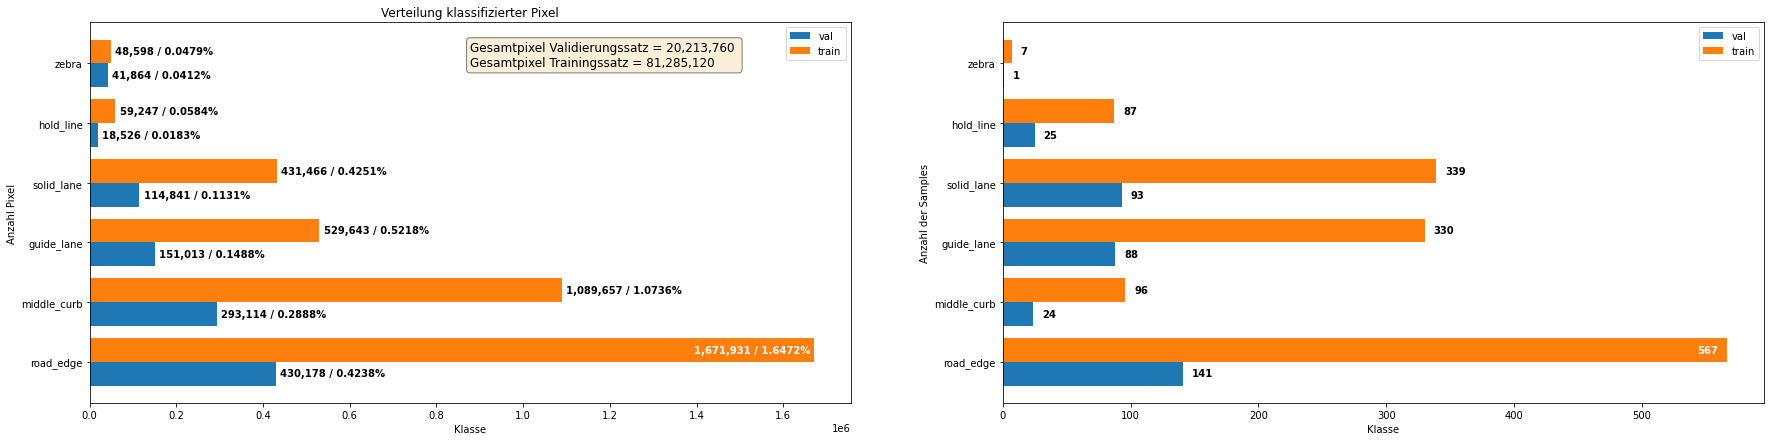

In [9]:
##########################################
# PLOT
#########################################
# val_data
_, val_data = val_gen.data_generation(val_input_img_paths, val_target_mask_paths)
val_ratio_data, _ = statistic.calc_ratio_data(val_data, number_classes, class_names)
sum_val_pixels = len(val_input_img_paths) * input_width * input_height
val_by_pixel, val_by_images = statistic.calc_chart_data(val_ratio_data, number_classes)
# train_data
_, train_data = train_gen.data_generation(train_input_img_paths, train_target_mask_paths)
train_ratio_data, _ = statistic.calc_ratio_data(train_data, number_classes, class_names)
sum_train_pixels = len(train_input_img_paths) * input_width * input_height
train_by_pixel, train_by_images = statistic.calc_chart_data(train_ratio_data, number_classes)
    
f, axs = plt.subplots(1,2,figsize=(30,7))
x_pos = np.array([i for i, _ in enumerate(class_names[:-1])])
bar1 = axs[0].barh(x_pos-0.2, val_by_pixel, height=0.4)
bar2 = axs[0].barh(x_pos+0.2, train_by_pixel, height=0.4)
axs[0].set_xlabel("Klasse")
axs[0].set_ylabel("Anzahl Pixel")
axs[0].title.set_text("Verteilung klassifizierter Pixel")
axs[0].set_yticks(x_pos)
axs[0].set_yticklabels(class_names[:-1])
axs[0].legend( (bar1, bar2), ('val', 'train') )

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
axs[0].text(0.5, 0.95, f'Gesamtpixel Validierungssatz = {sum_val_pixels:,.0f} \nGesamtpixel Trainingssatz = {sum_train_pixels:,.0f}', transform=axs[0].transAxes, fontsize=12, verticalalignment='top', bbox=props)
for rect in bar1 + bar2:
    width = rect.get_width()
    if width < 1_200_000:
        ha = 'left'
        pos = width + 10000
        color = 'black'
    else:
        ha = 'right'
        pos = width - 10000
        color = 'white'
    ratio = width / sum_all_pixels
    axs[0].text(pos, rect.get_y() + rect.get_height() / 2.0, f'{width:,.0f} / {ratio*100:.4f}%', ha=ha, va='center', color=color, fontweight='bold')

bar3 = axs[1].barh(x_pos-0.2, val_by_images, height=0.4)
bar4 = axs[1].barh(x_pos+0.2, train_by_images, height=0.4)
axs[1].set_xlabel("Klasse")
axs[1].set_ylabel("Anzahl der Samples")
axs[1].set_yticks(x_pos)
axs[1].set_yticklabels(class_names[:-1])
axs[1].legend( (bar3, bar4), ('val', 'train') )

for rect in bar3 + bar4:
    width = rect.get_width()
    if width < 500:
        ha = 'left'
        pos = width + 7
        color = 'black'
    else:
        ha = 'right'
        pos = width - 7
        color = 'white'
    axs[1].text(pos, rect.get_y() + rect.get_height() / 2.0, f'{width:,.0f}', ha=ha, va='center', color=color, fontweight='bold')

## Architecture

In [9]:
import architectures.unet as unet
import architectures.small_unet as small_unet
metrics = [sm.metrics.iou_score, evl.precision,evl.recall,evl.f1_score]

model = unet.tinyv2(name, input_height, input_width, number_classes, metrics)
# model = models_b.test_custom('LANESEGMENTATION_REFERENCE', input_height, input_width, number_classes, metrics)
#model = segmentation_model()|

plot_model(model, f"{output_dir}/model.png", show_shapes=True, show_dtype=False, show_layer_names=True)
print(model.summary())

/home/danielriege/env_train/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "test"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 640, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 320, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 320, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 320, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________________________

/home/danielriege/env_train/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [21]:
# checkpoint
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
sess = tf.compat.v1.Session(config=config)
    
filepath=f"{output_dir}/checkpoint.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

tf.get_logger().setLevel('ERROR')

history = model.fit(train_gen,
            validation_data=val_gen,
            epochs=epochs,
            use_multiprocessing=False,
            workers=6,
            callbacks=callbacks_list)
model.save(model_path)

2021-11-12 16:28:59.668989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 16:28:59.669807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 16:28:59.670229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 16:28:59.671924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 16:28:59.672135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Epoch 1/90
70/70 [==============================] - 33s 437ms/step - loss: 0.9438 - iou_score: 0.0323 - precision: 0.0675 - recall: 0.1723 - f1_score: 0.0945 - val_loss: 0.9533 - val_iou_score: 0.0278 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.95332, saving model to ./output/unet_tinyv2/checkpoint.h5


/home/danielriege/env_train/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/90
70/70 [==============================] - 30s 432ms/step - loss: 0.9020 - iou_score: 0.0578 - precision: 0.1839 - recall: 0.4228 - f1_score: 0.2501 - val_loss: 0.9390 - val_iou_score: 0.0388 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00

Epoch 00002: val_loss improved from 0.95332 to 0.93895, saving model to ./output/unet_tinyv2/checkpoint.h5
Epoch 3/90
12/70 [====>.........................] - ETA: 24s - loss: 0.8857 - iou_score: 0.0697 - precision: 0.1919 - recall: 0.5042 - f1_score: 0.2707

KeyboardInterrupt: 

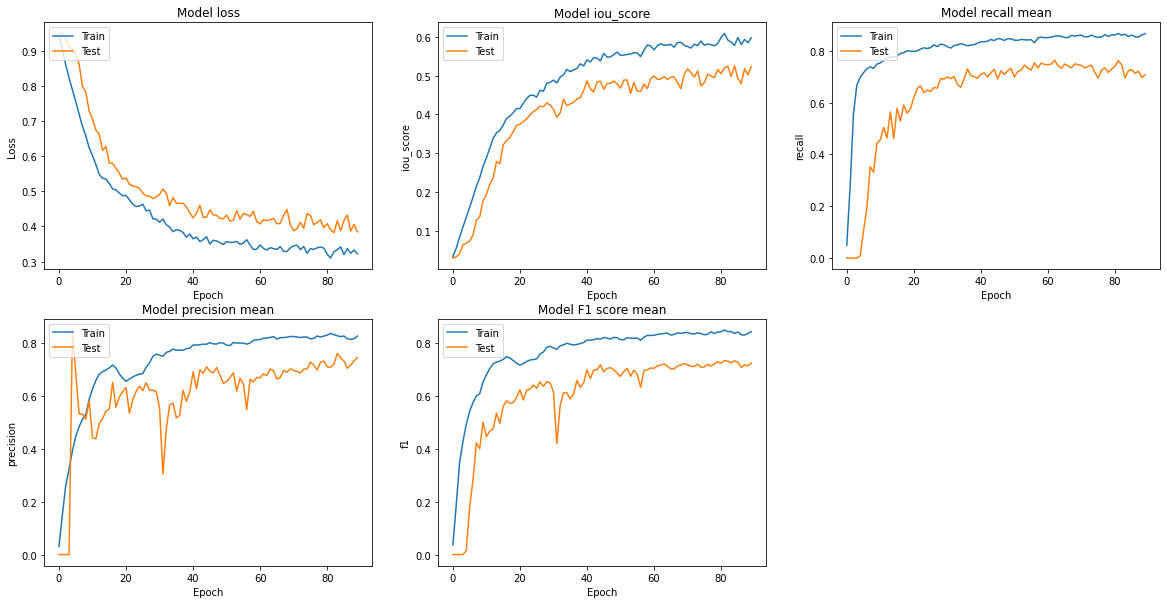

In [7]:
plt.figure(figsize=(20, 10))
# Plot training & validation loss values
plt.subplot(231)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation iou_score values
plt.subplot(232)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(233)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall mean')
plt.ylabel('recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(234)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model precision mean')
plt.ylabel('precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(235)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 score mean')
plt.ylabel('f1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


plt.savefig(f"{output_dir}/{name}_plot.png", bbox_inches="tight")
plt.show()

# Evaluation

In [3]:
# load model only if not trained in this session
model = load_model(f"{output_dir}/model.h5", custom_objects={'iou_score':sm.metrics.iou_score, 
                                                            'f1_score':evl.f1_score, 
                                                            'precision':evl.precision, 
                                                            'recall':evl.recall,
                                                            'tversky_loss': None})
# load test images
packages = ['knuff_main2']

# generate absolute list of all img and masks paths
image_paths = []
mask_paths = []
# for package
for index in range(len(packages)):
    image_base_path = f"{image_path}{packages[index]}/"
    masks_base_path = f"{annotation_path}{packages[index]}/masks/"

    file_list = os.listdir(masks_base_path)
    pattern = '*.png'
    for filename in file_list:
        if fnmatch.fnmatch(filename, pattern):
            mask_paths.append(os.path.join(masks_base_path, filename))
            image_name = filename[:len(filename)-3]+"jpg"
            image_paths.append(os.path.join(image_base_path, image_name))

test_batch_size = 16
params = {
    'batch_size': test_batch_size,
    'input_img_size': input_img_size,
    'target_img_size': (output_height, output_width),
    'shuffle': False,
    'n_channels': number_classes,
    'augmentation': False
}

test_gen = DataGenerator(image_paths, mask_paths, **params)

2021-11-14 16:02:41.149082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 16:02:41.164091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 16:02:41.164466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 16:02:41.165196: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

2021-11-14 16:02:46.736947: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 27525120 exceeds 10% of free system memory.
2021-11-14 16:02:46.746376: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 64225280 exceeds 10% of free system memory.
2021-11-14 16:02:46.800468: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-14 16:02:47.713157: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 27525120 exceeds 10% of free system memory.
2021-11-14 16:02:47.719913: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 64225280 exceeds 10% of free system memory.
2021-11-14 16:02:47.940088: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 27525120 exceeds 10% of free system memory.
2021-11-14 16:02:48.248347: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


Evaluation result:
Loss: 0.0 
IoU: 0.7992810010910034 
F1: 0.8659601807594299 
Precision: 0.8931081295013428 
Recall: 0.8792334794998169 



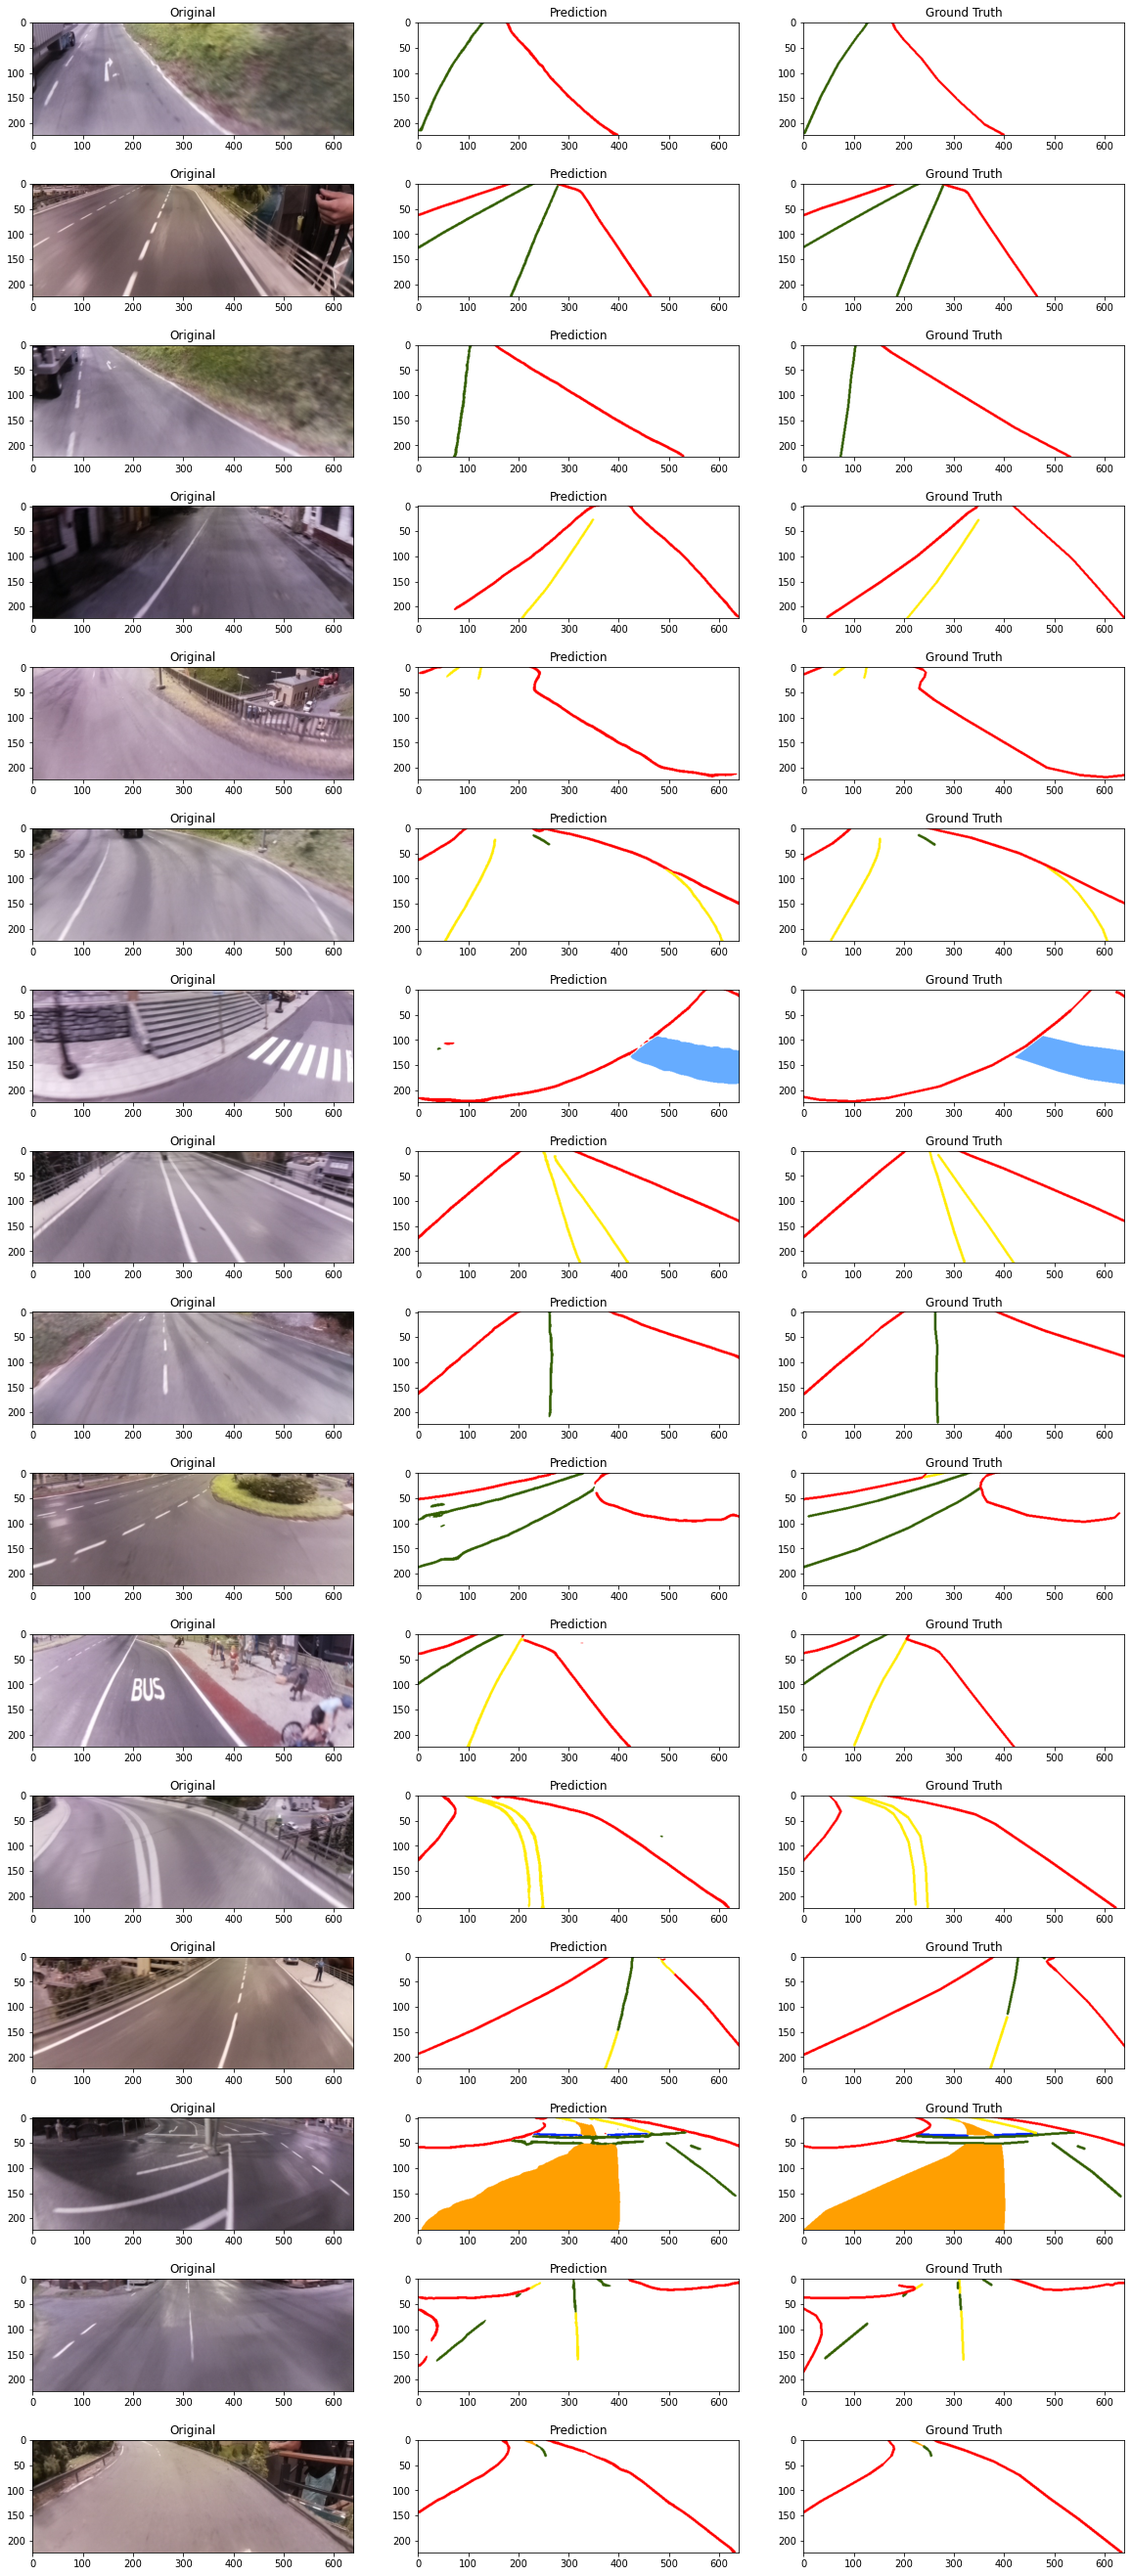

In [4]:
loss, iou, f1_score, precision, recall = model.evaluate(test_gen, verbose=0)
print("Evaluation result:")
print(f"Loss: {loss} \nIoU: {iou} \nF1: {f1_score} \nPrecision: {precision} \nRecall: {recall} \n")

testbatch_imgs = image_paths[:test_batch_size]
testbatch_masks = mask_paths[:test_batch_size]

imgs, masks = test_gen.data_generation(testbatch_imgs, testbatch_masks)

predictions = model.predict(imgs)

thres_value = 0.6

f, axs = plt.subplots(len(predictions), 3, figsize=(20,len(predictions)*3))
for i, prediction in enumerate(predictions):
    # show input img
    axs[i,0].imshow(imgs[i])
    axs[i,0].title.set_text('Original')
    
    # show prediction
    ## clip to 0 or 1 with thres
    clipped_pred = np.where(prediction > thres_value, 1, 0)
    rgb_pred = render.render_rgb(clipped_pred)
    
    axs[i,1].imshow(rgb_pred)
    axs[i,1].title.set_text('Prediction')
    # show ground truth|
    rgb_gt = render.render_rgb(masks[i].astype(int))
    
    axs[i,2].imshow(rgb_gt)
    axs[i,2].title.set_text('Ground Truth')
    

# TFLite

In [5]:
number_of_rep = 100
params = {
    'batch_size': number_of_rep,
    'input_img_size': input_img_size,
    'target_img_size': (output_height, output_width),
    'shuffle': False,
    'n_channels': number_classes,
    'augmentation': False
}
rep_gen = DataGenerator(image_paths, mask_paths, **params)
representative_imgs = image_paths[:number_of_rep]
representative_masks = mask_paths[:number_of_rep]

imgs, masks = rep_gen.data_generation(representative_imgs, representative_masks)


In [6]:
def representative_dataset():
    for img in imgs:
        data = np.expand_dims(img, axis=0)
        yield [data.astype(np.float32)]
        
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # or tf.uint8
converter.inference_output_type = tf.uint8  # or tf.uint8
tflite_quant_model = converter.convert()
open(f"{output_dir}/converted_model.tflite", "wb").write(tflite_quant_model)

2021-11-14 16:03:22.680869: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpy_atem1k/assets


/home/danielriege/env_train/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
2021-11-14 16:03:29.921010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 16:03:29.921243: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2021-11-14 16:03:29.921356: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-11-14 16:03:29.921620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retu

1597928

In [13]:
# Initialize the interpreter
interpreter = tf.lite.Interpreter(model_path=f"{output_dir}/converted_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

# Check if the input type is quantized, then rescale input data to uint8
outputs = np.zeros((imgs.shape[0], imgs.shape[1], imgs.shape[2], 7), dtype=np.uint8)
for i, img in enumerate(imgs):
    if input_details['dtype'] == np.uint8:
        input_scale, input_zero_point = input_details["quantization"]
        lite_img = np.array(img / input_scale + input_zero_point, dtype=np.uint8)
        lite_img = np.expand_dims(lite_img, axis=0)
        interpreter.set_tensor(input_details["index"], lite_img)
        interpreter.invoke()
        outputs[i] = interpreter.get_tensor(output_details["index"])
        

predictions = model.predict(imgs)
thres_value = 0.6

f, axs = plt.subplots(len(predictions), 4, figsize=(20,len(predictions)*3))
for i, prediction in enumerate(predictions):
    # show input img
    axs[i,0].imshow(imgs[i])
    axs[i,0].title.set_text('Original')
    
    # show prediction
    ## clip to 0 or 1 with thres
    clipped_pred = np.where(prediction > thres_value, 1, 0)
    rgb_pred = render.render_rgb(clipped_pred)
    
    axs[i,1].imshow(rgb_pred)
    axs[i,1].title.set_text('Prediction')
    
    ## clip to 0 or 1 with thres
    clipped_pred = np.where(outputs[i] > thres_value, 1, 0)
    rgb_pred = render.render_rgb(clipped_pred)
    
    axs[i,2].imshow(rgb_pred)
    axs[i,2].title.set_text('TFLite')
    
    # show ground truth|
    rgb_gt = render.render_rgb(masks[i].astype(int))
    
    axs[i,3].imshow(rgb_gt)
    axs[i,3].title.set_text('Ground Truth')


KeyboardInterrupt: 